In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr
logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

from plot_utils import plot_ground_truth_heatmap, plot_spike_grps
from sim_utils import load_regime_results, get_sim_params
from sim_utils import generate_regime_info, get_regime_info

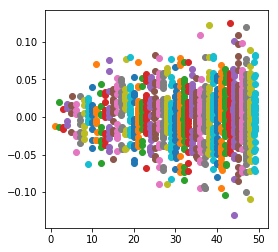

In [52]:
# plot points in a magatama
n_bins = 50
n_per_bin = 10
n_pts = n_per_bin * n_bins

means = np.arange(n_bins) # means
sdevs = np.log(1+np.arange(n_bins))/100 # sds
n_per_bin = ((np.arange(n_bins)))

fig, ax = plt.subplots(1,1,figsize=(4,4))
# generate noise
for i in range(n_bins):
    # generate normal variables with 
    sd = sdevs[i]
    m = means[i]
    n = n_per_bin[i]
    noise = sd*np.random.normal(size=(n,2))
    pos = noise + np.array([[m,0]])
    
# y_vals = np.zeros(n_pts)
    ax.scatter(*pos.T)
plt.show()

In [37]:
n_per_bin

array([ 1,  2,  5, 10, 17, 26, 37, 50, 65, 82])

[feat_viz INFO] [40]
[feat_viz INFO] {'seed': 0, 'n_samps': 35, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['mid', 'right', 'right', 'left', 'multi_left', 'multi_right'], 'n_repetitions': 1, 'rel_noise_list': [0.02]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 40, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [40]}
[feat_viz INFO] {'seed': 0, 'n_samps': 35, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['mid', 'right', 'right', 'left', 'multi_left', 'multi_right'], 'n_repetitions': 1, 'rel_noise_list': [0.02]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 40, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [40]}


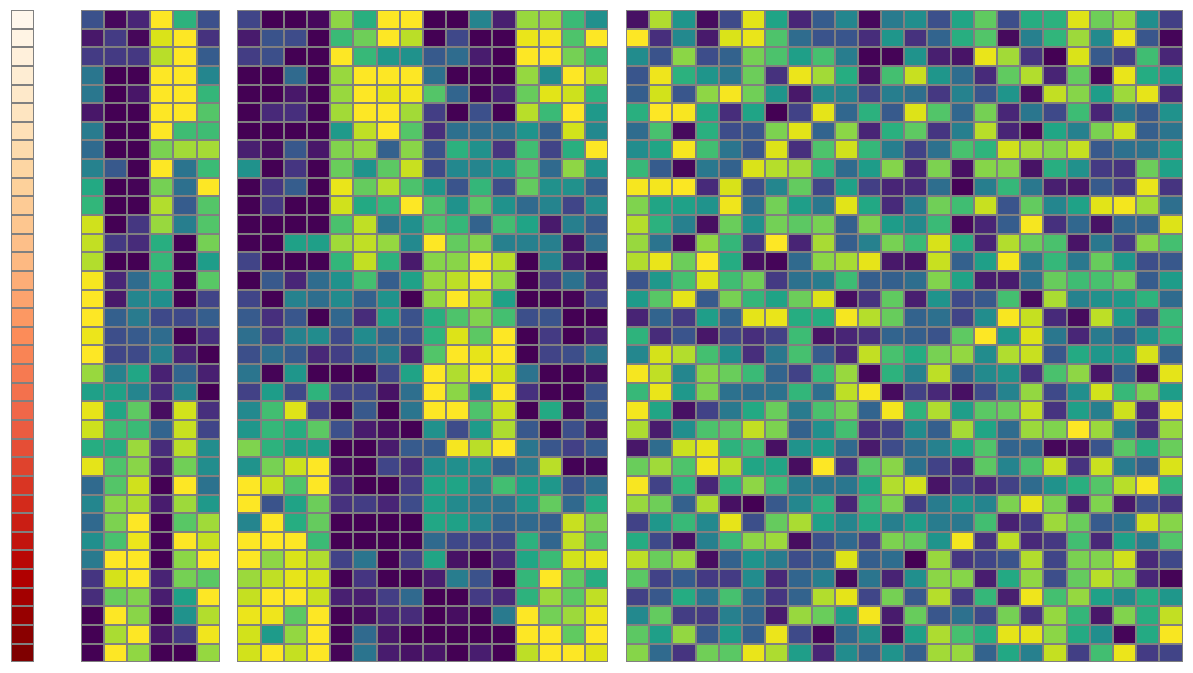

In [27]:
from sim_utils import generate_synthetic_data
from plot_utils import plot_main_example_figure
from plot_utils import plot_spikes_examples
from plot_utils import plot_base_heatmap
import matplotlib.gridspec as gridspec

sim_params = get_sim_params("main_sim_strict_1")
sim_params["n_samps"] = 35
sim_params["y_param"]["n_repetitions"] = 4
sim_params["x_param"]['spike_grp'] = [ 'mid', 'right', 'right', 'left', 'multi_left', 'multi_right']
sim_params["x_param"]['n_repetitions'] = 1
sim_params["x_param"]['rel_noise_list'] = [0.02]
sim_params["y_param"]['rel_noise_list'] = [5e-2]
sim_params["y_param"]['spike_grp'] = ['right', 'left', 'mid', 'mid_r']
sim_params['target_vars'] = 40
sim_params['n_var_list'] = [sim_params['target_vars']]
logger.info("{}".format(sim_params["n_var_list"]))

def plot_example_heatmap(sim_params, fn=None):
    lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
    l_mtx = np.expand_dims(lam, axis=1)
    fig = plt.figure(figsize=(21, 12))
    width_ratios = [l_mtx.shape[1],
                    l_mtx.shape[1]*0.5,
                    x_mtx.shape[1], 
                    y_mtx.shape[1], 
                    n_mtx.shape[1]]
    gs00 = gridspec.GridSpec(1, len(width_ratios), 
                            figure=fig,
                            width_ratios=width_ratios,
                            wspace=0.08, hspace=0.2)
    ax = plt.subplot(gs00[0, 0])
    ax = plot_base_heatmap(l_mtx, ax=ax, cmap="OrRd")
    ax = plt.subplot(gs00[0, 2])
    ax = plot_base_heatmap(x_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 3])
    ax = plot_base_heatmap(y_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 4])
    ax = plot_base_heatmap(n_mtx, ax=ax) 
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return

lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
plot_example_heatmap(sim_params)

## Generate some visualizations for the liver

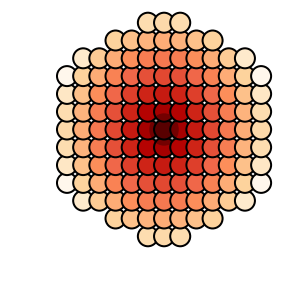

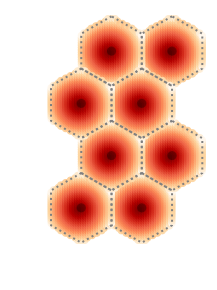

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from plot_utils import draw_liver_lobule
  
def save_figure(fn):
    plt.savefig(fn, bbox_inches='tight', transparent=True) 
    logger.info("Saved figure to: {}".format(fn))

def plot_liver_lobule(res="mid", fn=None):
    if res == "mid":
        fig, ax = plt.subplots(1, 1, figsize=(3,4.5))
        draw_liver_lobule(ax)
        ax.axis("off")
    if res == "high":
        fig, ax = plt.subplots(1, 1, figsize=(4,4.5))
        draw_liver_lobule(ax, single=True)
        ax.axis("off")
    if fn:
        save_figure(fn)
    else:
        plt.show()
plot_liver_lobule(res="high")
plot_liver_lobule(res="mid")

## Plot Toy Heatmap

[feat_viz INFO] [36]


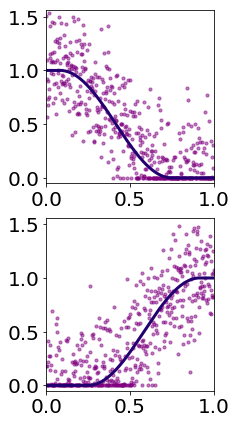

[feat_viz INFO] {'seed': 0, 'n_samps': 25, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 3, 'rel_noise_list': [0.1]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 36, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [36]}


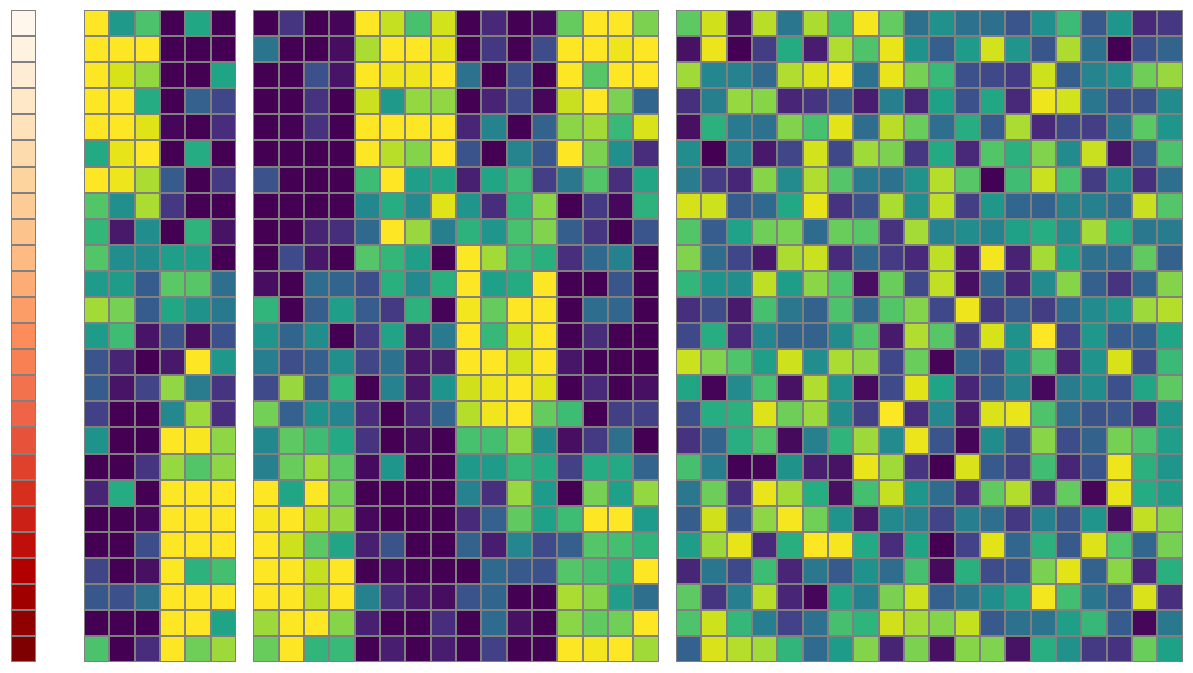

In [6]:


sim_params = get_sim_params("main_sim_strict_1")
sim_params["n_samps"] = 25
sim_params["y_param"]["n_repetitions"] = 4
sim_params["x_param"]['n_repetitions'] = 3
sim_params["x_param"]['rel_noise_list'] = [0.1]
sim_params["y_param"]['rel_noise_list'] = [5e-2]
sim_params["y_param"]['spike_grp'] = ['right', 'left', 'mid', 'mid_r']
sim_params['target_vars'] = 36
sim_params['n_var_list'] = [sim_params['target_vars']]
logger.info("{}".format(sim_params["n_var_list"]))

def plot_knowledge_anchors(sim_params, fn=None):
    nlist =  sim_params["x_param"]['rel_noise_list'] + [0]
    xspikes = sim_params["x_param"]['spike_grp']
    fig, ax = plt.subplots(2, 1, figsize=(3, 7))
    plot_spikes_examples(ax[0], xspikes[0], nlist)
    plot_spikes_examples(ax[1], xspikes[1], nlist)
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return

def plot_example_heatmap(sim_params, fn=None):
    lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
    l_mtx = np.expand_dims(lam, axis=1)
    fig = plt.figure(figsize=(21, 12))
    width_ratios = [l_mtx.shape[1],
                    l_mtx.shape[1]*0.5,
                    x_mtx.shape[1], 
                    y_mtx.shape[1], 
                    n_mtx.shape[1]]
    gs00 = gridspec.GridSpec(1, len(width_ratios), 
                            figure=fig,
                            width_ratios=width_ratios,
                            wspace=0.08, hspace=0.2)
    ax = plt.subplot(gs00[0, 0])
    ax = plot_base_heatmap(l_mtx, ax=ax, cmap="OrRd")
    ax = plt.subplot(gs00[0, 2])
    ax = plot_base_heatmap(x_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 3])
    ax = plot_base_heatmap(y_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 4])
    ax = plot_base_heatmap(n_mtx, ax=ax) 
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return
    
plot_knowledge_anchors(sim_params)
plot_example_heatmap(sim_params)

## Save Figures to File

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_liver_single.pdf
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_liver.pdf
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_predom.pdf
[feat_viz INFO] {'seed': 0, 'n_samps': 25, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 3, 'rel_noise_list': [0.1]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 36, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [36]}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_mtx.pdf


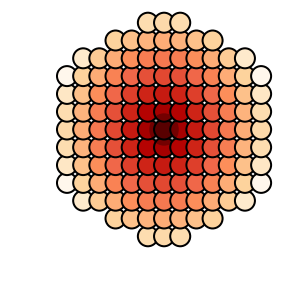

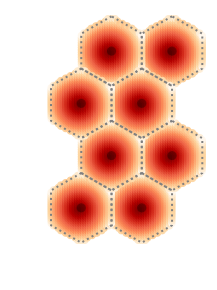

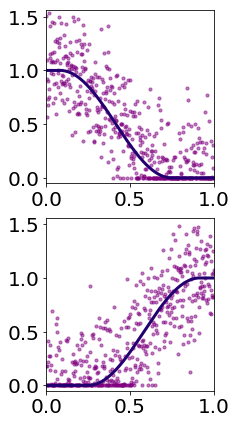

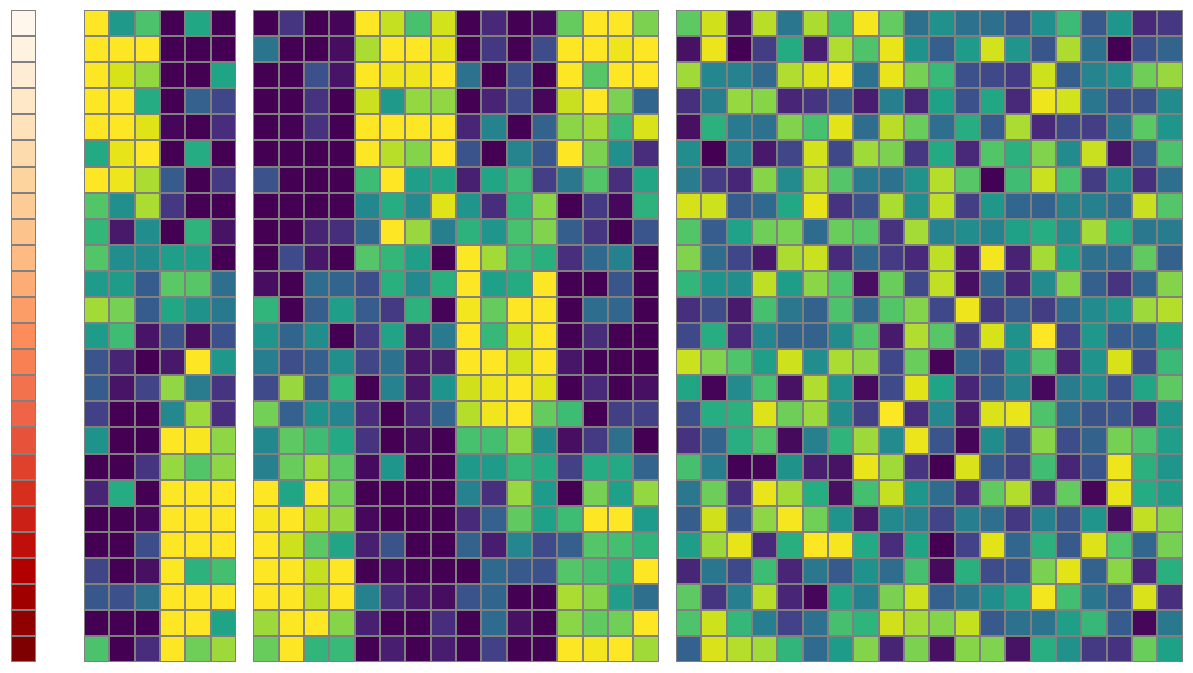

In [7]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"
fn = os.path.join(FDIR, "main_fig_liver_single.pdf")
plot_liver_lobule(res="high", fn=fn)
fn = os.path.join(FDIR, "main_fig_liver.pdf")
plot_liver_lobule(res="mid", fn=fn)
fn = os.path.join(FDIR, "main_fig_predom.pdf")
plot_knowledge_anchors(sim_params, fn=fn)
fn = os.path.join(FDIR, "main_fig_mtx.pdf")
plot_example_heatmap(sim_params, fn=fn)